In [3]:
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt


In [20]:
class PairedImageDataset(Dataset):
    def __init__(self, lr_txt_path, hr_txt_path, root_lr, root_hr):
        with open(lr_txt_path, 'r') as f:
            self.lr_paths = [line.strip() for line in f]
        with open(hr_txt_path, 'r') as f:
            self.hr_paths = [line.strip() for line in f]

        self.root_lr = root_lr
        self.root_hr = root_hr

        self.hr_transform = transforms.ToTensor()
        self.lr_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((512, 512), antialias=True)  # Upsample low-res to match HR shape
        ])

    def __getitem__(self, idx):
        lr_path = os.path.join(self.root_lr, self.lr_paths[idx])
        hr_path = os.path.join(self.root_hr, self.hr_paths[idx])

        lr_img = self.lr_transform(Image.open(lr_path))
        hr_img = self.hr_transform(Image.open(hr_path))

        return lr_img.flatten(), hr_img.flatten()

    def __len__(self):
        return len(self.lr_paths)


In [21]:
base_dir = "/mnt/tcia_data/processed/NSCLC-Radiomics"
lr_txt = os.path.join(base_dir, "splits", "train_lr.txt")
hr_txt = os.path.join(base_dir, "splits", "train_hr.txt")
lr_dir = os.path.join(base_dir, "images_lr_x2")
hr_dir = os.path.join(base_dir, "images_hr")

dataset = PairedImageDataset(lr_txt, hr_txt, lr_dir, hr_dir)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)


In [25]:
class FlowMLP(nn.Module):
    def __init__(self, dim=512*512):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim + 1, 1024),
            nn.ReLU(),
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.Linear(1024, dim)
        )

    def forward(self, x, t):
        t = t.view(-1, 1)
        xt = torch.cat([x, t], dim=1)
        return self.net(xt)


In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FlowMLP().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


In [27]:
n_epochs = 10
losses = []

for epoch in range(n_epochs):
    total_loss = 0
    model.train()

    for x0, x1 in tqdm(dataloader, desc=f"Epoch {epoch+1}"):
        x0, x1 = x0.to(device), x1.to(device)
        t = torch.rand(x0.size(0), 1, device=device)
        xt = (1 - t) * x0 + t * x1
        target = x1 - x0

        pred = model(xt, t)
        loss = ((pred - target) ** 2).mean()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    losses.append(avg_loss)
    print(f"Epoch {epoch+1} Loss: {avg_loss:.4f}")


Epoch 1: 100%|██████████| 1111/1111 [04:17<00:00,  4.32it/s]


Epoch 1 Loss: 0.0009


Epoch 2: 100%|██████████| 1111/1111 [04:21<00:00,  4.25it/s]


Epoch 2 Loss: 0.0005


Epoch 3: 100%|██████████| 1111/1111 [04:17<00:00,  4.31it/s]


Epoch 3 Loss: 0.0005


Epoch 4: 100%|██████████| 1111/1111 [04:14<00:00,  4.37it/s]


Epoch 4 Loss: 0.0005


Epoch 5: 100%|██████████| 1111/1111 [04:14<00:00,  4.36it/s]


Epoch 5 Loss: 0.0005


Epoch 6: 100%|██████████| 1111/1111 [04:13<00:00,  4.38it/s]


Epoch 6 Loss: 0.0005


Epoch 7: 100%|██████████| 1111/1111 [04:16<00:00,  4.33it/s]


Epoch 7 Loss: 0.0005


Epoch 8: 100%|██████████| 1111/1111 [04:15<00:00,  4.36it/s]


Epoch 8 Loss: 0.0005


Epoch 9: 100%|██████████| 1111/1111 [04:15<00:00,  4.35it/s]


Epoch 9 Loss: 0.0005


Epoch 10: 100%|██████████| 1111/1111 [04:26<00:00,  4.17it/s]

Epoch 10 Loss: 0.0005


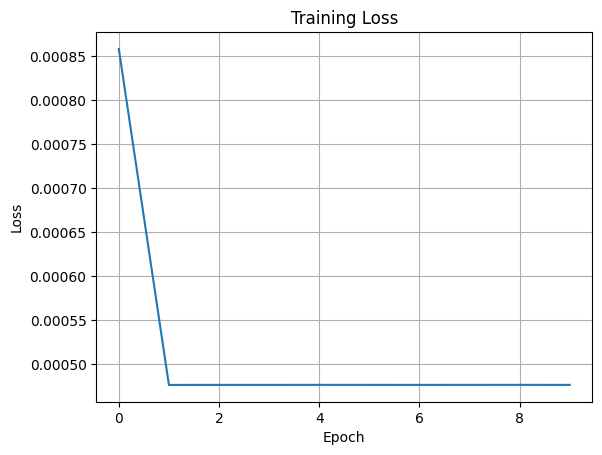

In [28]:
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.grid(True)
plt.show()


In [29]:
losses

[0.0008578345341030357,
 0.0004760173922086103,
 0.0004760569936937873,
 0.00047606287355820583,
 0.0004760931765136303,
 0.00047607618561358226,
 0.0004760670066164835,
 0.00047608067192582367,
 0.00047609677535551326,
 0.00047605576792741943]

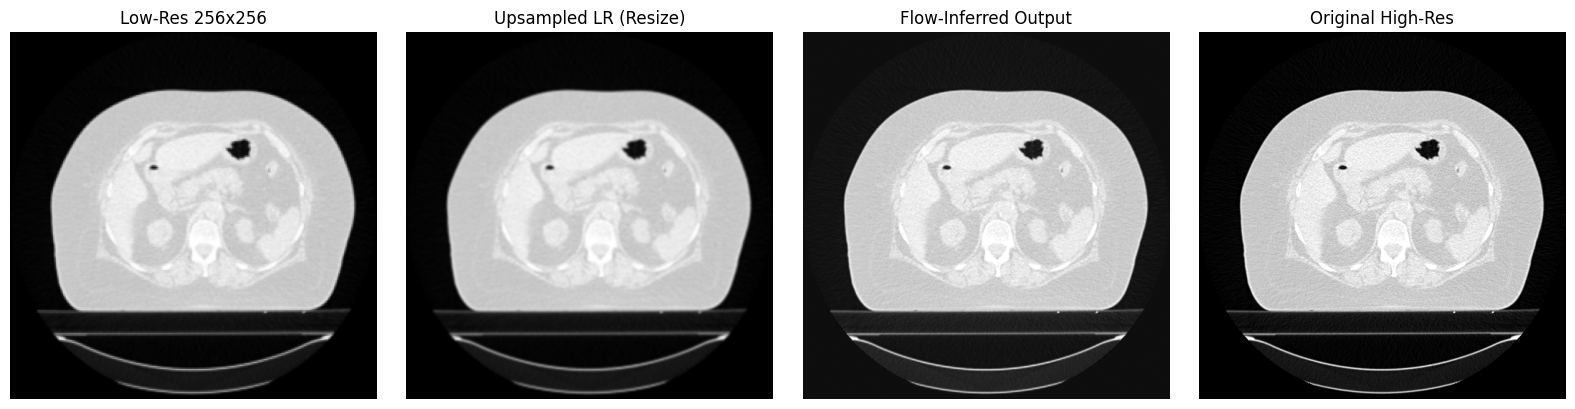

In [30]:
from torchvision.transforms.functional import resize

model.eval()
with torch.no_grad():
    x0, x1 = next(iter(dataloader))  # Get one batch
    x0, x1 = x0.to(device), x1.to(device)
    t = torch.full((x0.size(0), 1), 0.5, device=device)

    xt = (1 - t) * x0 + t * x1
    velocity = model(xt, t)
    inferred = xt + 0.5 * velocity  # Euler step with dt = 0.5

    # Select one sample
    i = 0

    # Original low-res image (256x256)
    img_lr = x0[i].cpu().reshape(1, 512, 512)  # because we upsampled earlier
    img_hr = x1[i].cpu().reshape(512, 512)
    img_inf = inferred[i].cpu().reshape(512, 512)

    # Resize low-res image down (simulate original 256x256) and then back up (512x512)
    img_lr_256 = resize(img_lr, size=[256, 256])  # simulate actual stored LR image
    img_lr_up = resize(img_lr_256, size=[512, 512])  # what transforms.Resize would have done

    # Display
    fig, axs = plt.subplots(1, 4, figsize=(16, 4))
    axs[0].imshow(img_lr_256.squeeze(0), cmap='gray')
    axs[0].set_title("Low-Res 256x256")
    axs[0].axis("off")

    axs[1].imshow(img_lr_up.squeeze(0), cmap='gray')
    axs[1].set_title("Upsampled LR (Resize)")
    axs[1].axis("off")

    axs[2].imshow(img_inf, cmap='gray')
    axs[2].set_title("Flow-Inferred Output")
    axs[2].axis("off")

    axs[3].imshow(img_hr, cmap='gray')
    axs[3].set_title("Original High-Res")
    axs[3].axis("off")

    plt.tight_layout()
    plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.06163288..1.0059384].


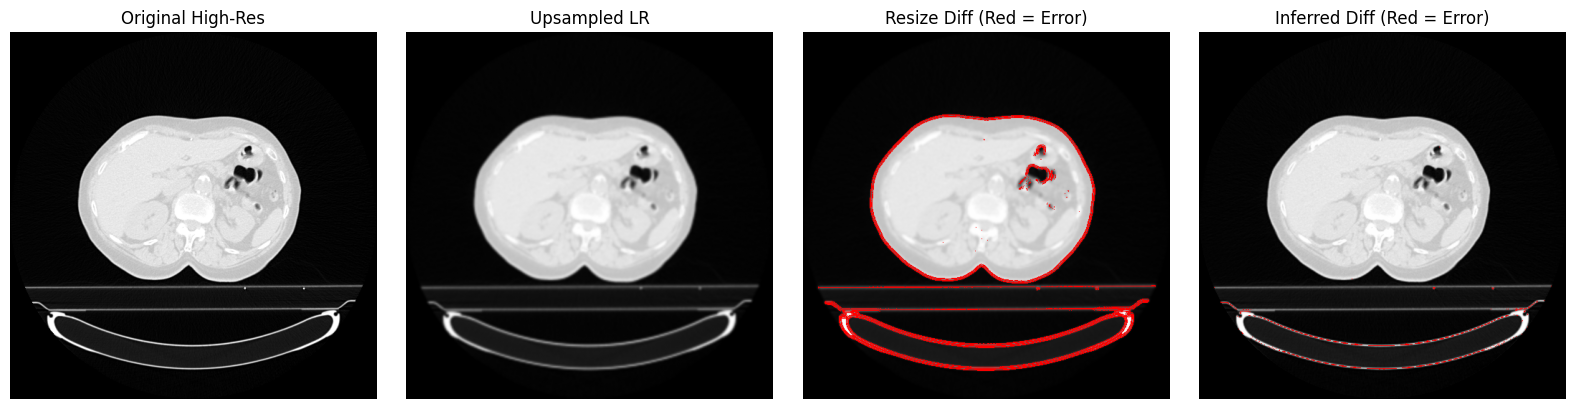

In [31]:
import numpy as np

model.eval()
with torch.no_grad():
    x0, x1 = next(iter(dataloader))
    x0, x1 = x0.to(device), x1.to(device)
    t = torch.full((x0.size(0), 1), 0.5, device=device)

    xt = (1 - t) * x0 + t * x1
    velocity = model(xt, t)
    inferred = xt + 0.5 * velocity

    i = 0
    img_lr = x0[i].cpu().reshape(1, 512, 512)
    img_hr = x1[i].cpu().reshape(512, 512)
    img_inf = inferred[i].cpu().reshape(512, 512)

    # Simulate original 256x256 LR image, then upsample
    img_lr_256 = resize(img_lr, size=[256, 256])
    img_lr_up = resize(img_lr_256, size=[512, 512]).squeeze(0)

    # Compute difference maps
    diff_inf = torch.abs(img_inf - img_hr)
    diff_up = torch.abs(img_lr_up - img_hr)

    # Threshold to get binary masks
    red_inf = (diff_inf > 0.1).numpy()  # you can tweak threshold
    red_up = (diff_up > 0.1).numpy()

    def overlay_red(base_img, red_mask):
        base = np.stack([base_img.numpy()] * 3, axis=-1)  # convert to RGB
        base[red_mask, 0] = 1.0  # red channel
        base[red_mask, 1] = 0.0  # green
        base[red_mask, 2] = 0.0  # blue
        return base

    # Prepare overlays
    inf_overlay = overlay_red(img_inf, red_inf)
    up_overlay = overlay_red(img_lr_up, red_up)

    # Plot all
    fig, axs = plt.subplots(1, 4, figsize=(16, 4))

    axs[0].imshow(img_hr, cmap='gray')
    axs[0].set_title("Original High-Res")
    axs[0].axis("off")

    axs[1].imshow(img_lr_up, cmap='gray')
    axs[1].set_title("Upsampled LR")
    axs[1].axis("off")

    axs[2].imshow(up_overlay)
    axs[2].set_title("Resize Diff (Red = Error)")
    axs[2].axis("off")

    axs[3].imshow(inf_overlay)
    axs[3].set_title("Inferred Diff (Red = Error)")
    axs[3].axis("off")

    plt.tight_layout()
    plt.show()


In [32]:
# Paths for test split
test_lr_txt = os.path.join(base_dir, "splits", "test_lr.txt")
test_hr_txt = os.path.join(base_dir, "splits", "test_hr.txt")

# Create test dataset
test_dataset = PairedImageDataset(test_lr_txt, test_hr_txt, lr_dir, hr_dir)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.06841209..1.0010053].


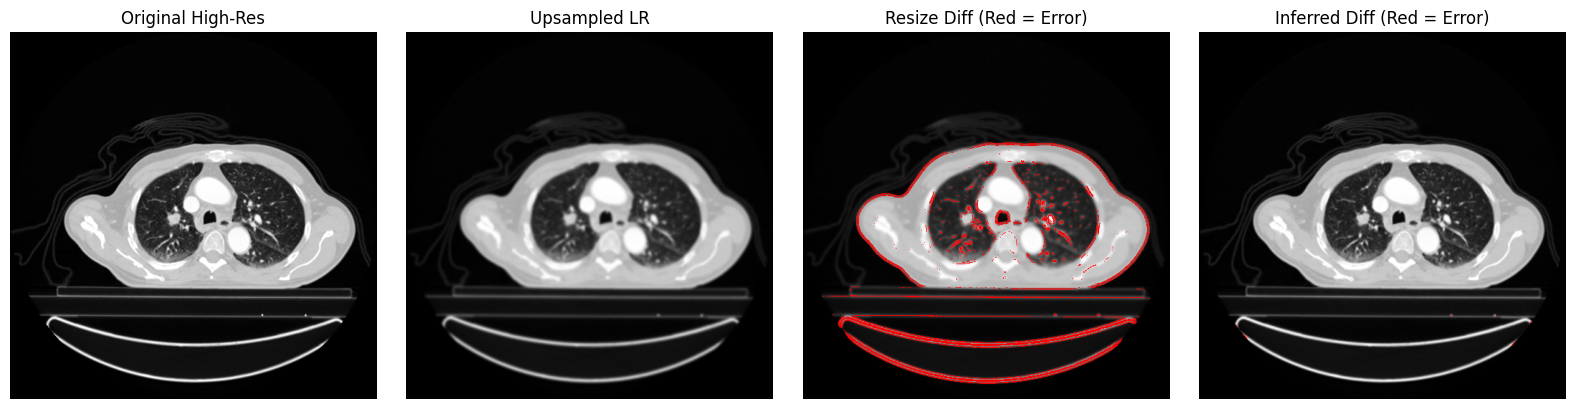

In [34]:
model.eval()
with torch.no_grad():
    x0, x1 = next(iter(test_loader))
    x0, x1 = x0.to(device), x1.to(device)
    t = torch.full((x0.size(0), 1), 0.5, device=device)

    xt = (1 - t) * x0 + t * x1
    velocity = model(xt, t)
    inferred = xt + 0.5 * velocity

    i = 0
    img_lr = x0[i].cpu().reshape(1, 512, 512)
    img_hr = x1[i].cpu().reshape(512, 512)
    img_inf = inferred[i].cpu().reshape(512, 512)

    # Simulate original 256x256 LR image, then upsample
    img_lr_256 = resize(img_lr, size=[256, 256])
    img_lr_up = resize(img_lr_256, size=[512, 512]).squeeze(0)

    # Compute difference maps
    diff_inf = torch.abs(img_inf - img_hr)
    diff_up = torch.abs(img_lr_up - img_hr)

    # Threshold to get binary masks
    red_inf = (diff_inf > 0.1).numpy()  # you can tweak threshold
    red_up = (diff_up > 0.1).numpy()

    def overlay_red(base_img, red_mask):
        base = np.stack([base_img.numpy()] * 3, axis=-1)  # convert to RGB
        base[red_mask, 0] = 1.0  # red channel
        base[red_mask, 1] = 0.0  # green
        base[red_mask, 2] = 0.0  # blue
        return base

    # Prepare overlays
    inf_overlay = overlay_red(img_inf, red_inf)
    up_overlay = overlay_red(img_lr_up, red_up)

    # Plot all
    fig, axs = plt.subplots(1, 4, figsize=(16, 4))

    axs[0].imshow(img_hr, cmap='gray')
    axs[0].set_title("Original High-Res")
    axs[0].axis("off")

    axs[1].imshow(img_lr_up, cmap='gray')
    axs[1].set_title("Upsampled LR")
    axs[1].axis("off")

    axs[2].imshow(up_overlay)
    axs[2].set_title("Resize Diff (Red = Error)")
    axs[2].axis("off")

    axs[3].imshow(inf_overlay)
    axs[3].set_title("Inferred Diff (Red = Error)")
    axs[3].axis("off")

    plt.tight_layout()
    plt.show()
